> # Machine Learning for house price prediction 

In [25]:
import matplotlib.pyplot as plt
import math
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from tabulate import tabulate
from scipy.stats import norm
from IPython.display import display
from pandas.api.types import CategoricalDtype
import warnings

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# 1. Creating functions for pre-processing & EDA

In [7]:
def load_data():
    # Read data
    data_dir = Path(r"/kaggle/input/house-prices-advanced-regression-techniques")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = preprocess(df)
    #df = encode(df)
    #df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [5]:
def preprocess(df):
    # Drop columns with more than 80% missing values
    missing_percentage = df.isnull().sum() / len(df)
    columns_to_drop = missing_percentage[missing_percentage > 0.8].index
    df = df.drop(columns_to_drop, axis=1)

    # Fixing the missing values in Lotfrontage by the average lotfrontage under the mszoning category
    df['LotFrontage'] = df.groupby('MSZoning')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

    # Some values of GarageYrBlt are corrupt, so we'll replace them with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Also filling the missing values in GarageYrBlt with YearBuilt
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True)

    # The nominative (unordered) categorical features
    features_nom = [
        "MSSubClass", "MSZoning", "Street", "LandContour", "LotConfig", "Neighborhood",
        "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st",
        "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature",
        "SaleType", "SaleCondition"
    ]

    # The ordinal (ordered) categorical features 
    five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
    ten_levels = list(range(1, 11))

    ordered_levels = {
        "OverallQual": ten_levels,
        "OverallCond": ten_levels,
        "ExterQual": five_levels,
        "ExterCond": five_levels,
        "BsmtQual": five_levels,
        "BsmtCond": five_levels,
        "HeatingQC": five_levels,
        "KitchenQual": five_levels,
        "FireplaceQu": five_levels,
        "GarageQual": five_levels,
        "GarageCond": five_levels,
        "PoolQC": five_levels,
        "LotShape": ["Reg", "IR1", "IR2", "IR3"],
        "LandSlope": ["Sev", "Mod", "Gtl"],
        "BsmtExposure": ["No", "Mn", "Av", "Gd"],
        "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
        "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
        "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
        "GarageFinish": ["Unf", "RFn", "Fin"],
        "PavedDrive": ["N", "P", "Y"],
        "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
        "CentralAir": ["N", "Y"],
        "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
        "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
    }

    # Add a None level for missing values
    ordered_levels = {key: ["None"] + value for key, value in ordered_levels.items()}

    # Nominal categories
    for name in features_nom:
        if name in df.columns:
            df[name] = df[name].astype("category")
            # Add a None category for missing values
            if "None" not in df[name].cat.categories:
                df[name].cat.add_categories("None", inplace=True)

    # Ordinal categories
    for name, levels in ordered_levels.items():
        if name in df.columns:
            df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))

    # Impute missing values
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)

    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")

    return df


In [8]:
#The Train & Test split
df_train, df_test = load_data()

In [9]:
def print_summary(df):
    summary_data = []
    for column in df.columns:
        summary_data.append([
            column,
            df[column].dtype,
            df[column].nunique(),
            df[column].isnull().sum()
        ])

    print("Main Features:")
    headers = ["Column", "Data Type", "Unique Values", "Missing Values"]
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))

In [10]:

def print_summary_stats(column_name, data):
    column_stats = data[column_name].describe()
    summary_data = [
        ["Count", column_stats['count']],
        ["Mean", column_stats['mean']],
        ["Std", column_stats['std']],
        ["Min", column_stats['min']],
        ["25%", column_stats['25%']],
        ["50% (Median)", column_stats['50%']],
        ["75%", column_stats['75%']],
        ["Max", column_stats['max']]
    ]
    headers = ["Statistic", "Value"]
    print(f"{column_name} Summary Statistics:")
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))

In [30]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
def plot_distribution_and_normality(df, column_name):
    # Make a copy of the DataFrame
    df_copy = df.copy()

    # Create the figure and axes for the subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    # Plot the first histogram and normal probability plot
    sns.distplot(df[column_name], fit=stats.norm, ax=axes[0, 0])
    stats.probplot(df[column_name], plot=axes[0, 1])

    # Apply log transformation to the copy of the column
    df_copy[column_name] = np.log(df_copy[column_name])

    # Plot the second histogram and normal probability plot
    sns.distplot(df_copy[column_name], fit=stats.norm, ax=axes[1, 0])
    stats.probplot(df_copy[column_name], plot=axes[1, 1])

    # Set titles for the subplots
    axes[0, 0].set_title('Histogram (Original)')
    axes[0, 1].set_title('Normal Probability Plot (Original)')
    axes[1, 0].set_title('Histogram (Log Transformed)')
    axes[1, 1].set_title('Normal Probability Plot (Log Transformed)')

    # Adjust the layout and spacing
    plt.tight_layout()

    # Display the plots
    plt.show()


In [12]:
def plot_boxplot(df, x_column, y_column):
    data = df[[x_column, y_column]]
    fig, ax = plt.subplots(figsize=(14, 9))
    sns.boxplot(x=x_column, y=y_column, data=data, ax=ax)
    ax.set_ylim(0, 800000)
    plt.xticks(rotation=90)
    plt.title(f'Boxplot of {y_column} by {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

In [13]:
def plot_heatmaps(df):
    # Correlation Matrix Heatmap
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(corrmat, vmax=.8, square=True, cmap="RdBu")
    plt.title('Correlation Matrix Heatmap')
    plt.show()

    # Top Variables Heatmap
    k = 10  # number of variables for heatmap
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.25)
    f, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                yticklabels=cols.values, xticklabels=cols.values, cmap="RdBu")
    plt.title('Top K most correlate variables')
    plt.show()


In [35]:

def plot_histograms(data, figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8):
    num_cols = len(data.columns)
    grid_size = math.ceil(math.sqrt(num_cols))
    fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=figsize)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust the vertical and horizontal spacing between subplots

    for i, column in enumerate(data.columns):
        ax = axes[i // grid_size, i % grid_size]

        if data[column].dtype == 'object':
            # Categorical column
            value_counts = data[column].value_counts()
            ax.bar(value_counts.index, value_counts.values, color='steelblue', edgecolor='black')
            ax.set_xticks(range(len(value_counts.index)))
            ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
        else:
            # Numerical column
            ax.hist(data[column], bins=bins, edgecolor='black', color='skyblue')

        ax.set_xlabel(column, fontsize=xlabelsize)
        ax.set_ylabel('Frequency', fontsize=ylabelsize)
        ax.tick_params(axis='both', which='both', labelsize=xlabelsize)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Remove empty subplots if the number of columns is not a perfect square
    if num_cols < grid_size * grid_size:
        for i in range(num_cols, grid_size * grid_size):
            fig.delaxes(axes[i // grid_size, i % grid_size])

    plt.show()


# Part 2: EDA

# Feature summary of the dataset

In [15]:
print_summary(df_train)

Main Features:
+------------------+-------------+-----------------+------------------+
| Column           | Data Type   |   Unique Values |   Missing Values |
+==================+=============+=================+==================+
| MSSubClass       | category    |              15 |                0 |
+------------------+-------------+-----------------+------------------+
| MSZoning         | category    |               5 |                0 |
+------------------+-------------+-----------------+------------------+
| LotFrontage      | float64     |             114 |                0 |
+------------------+-------------+-----------------+------------------+
| LotArea          | int64       |            1073 |                0 |
+------------------+-------------+-----------------+------------------+
| Street           | category    |               2 |                0 |
+------------------+-------------+-----------------+------------------+
| LotShape         | category    |               

# Summary of the dependent variavle

In [16]:
print_summary_stats('SalePrice', df_train)

SalePrice Summary Statistics:
+--------------+----------+
| Statistic    |    Value |
+==============+==========+
| Count        |   1460   |
+--------------+----------+
| Mean         | 180921   |
+--------------+----------+
| Std          |  79442.5 |
+--------------+----------+
| Min          |  34900   |
+--------------+----------+
| 25%          | 129975   |
+--------------+----------+
| 50% (Median) | 163000   |
+--------------+----------+
| 75%          | 214000   |
+--------------+----------+
| Max          | 755000   |
+--------------+----------+


# Distrubution of the dependent variable  (sale price) # 

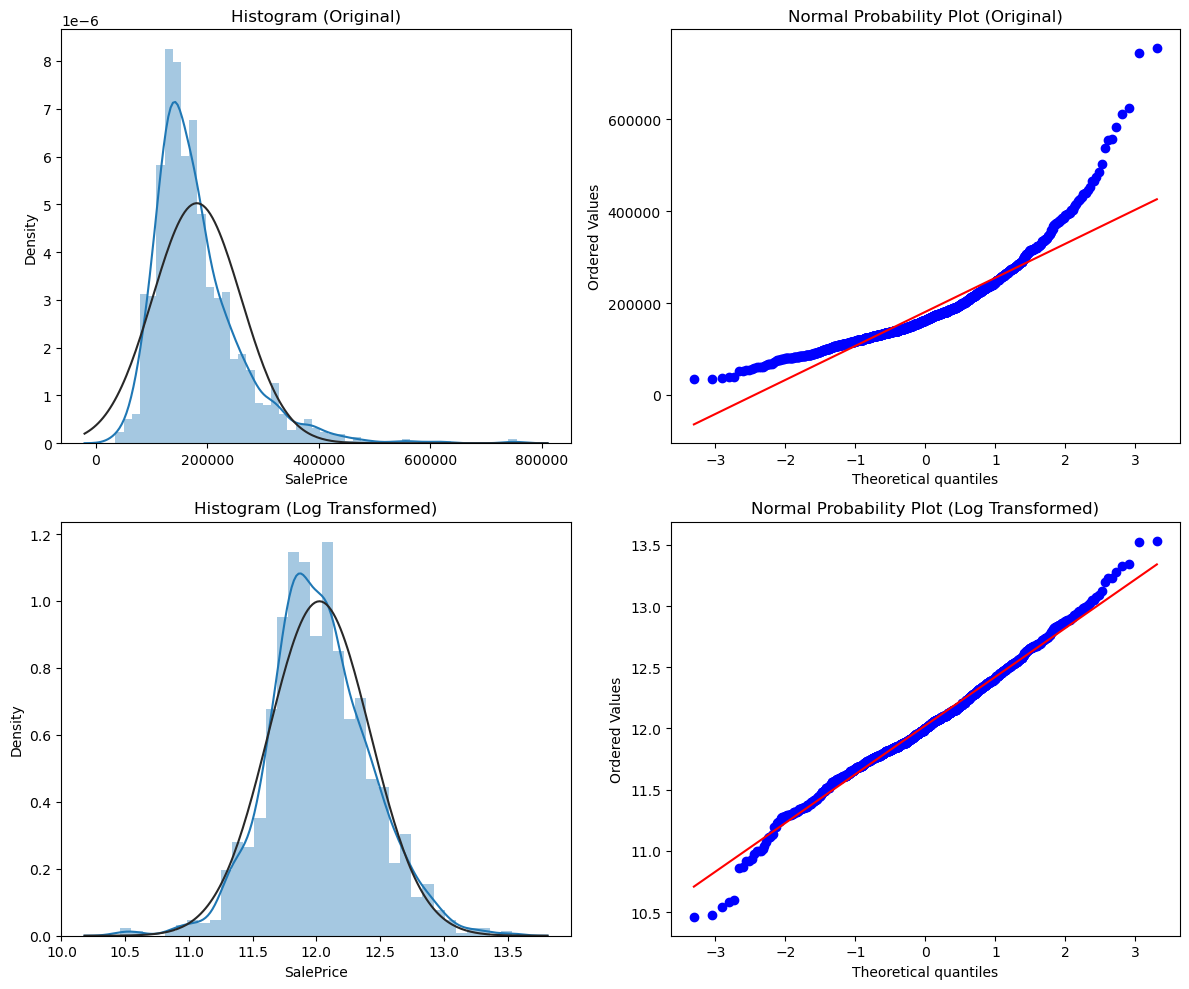

In [31]:
from scipy.stats import norm
plot_distribution_and_normality(df_train, 'SalePrice')

# 

# Impact of Quality on sale price

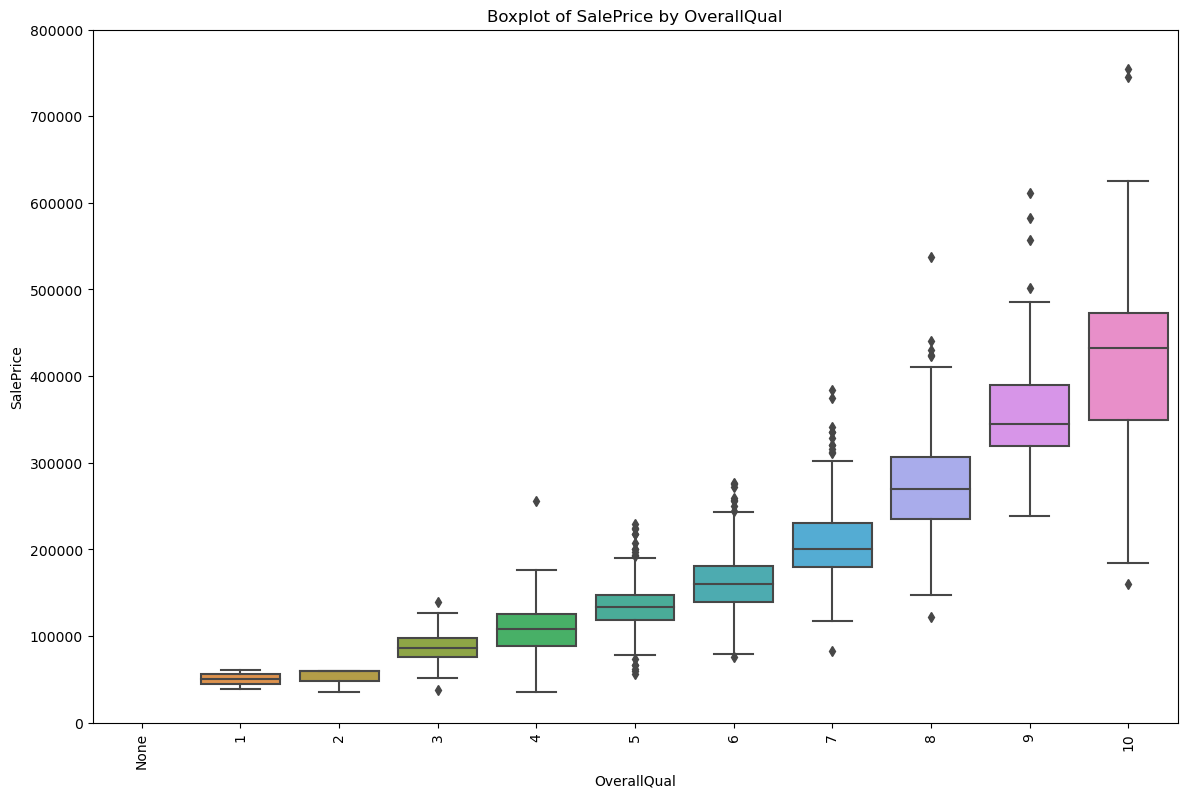

In [32]:
plot_boxplot(df_train, 'OverallQual', 'SalePrice')

# Impact of Year on sale price

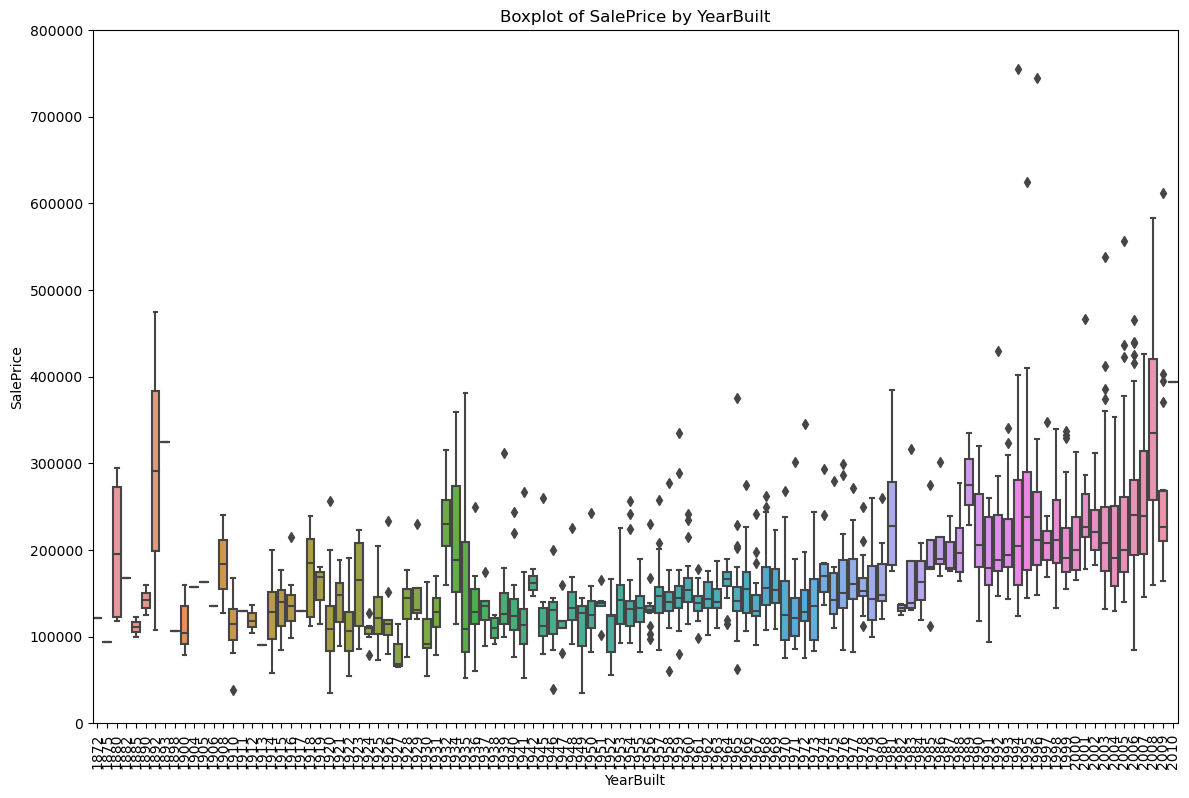

In [33]:
plot_boxplot(df_train, 'YearBuilt', 'SalePrice')

# Frequency distribution of the variables

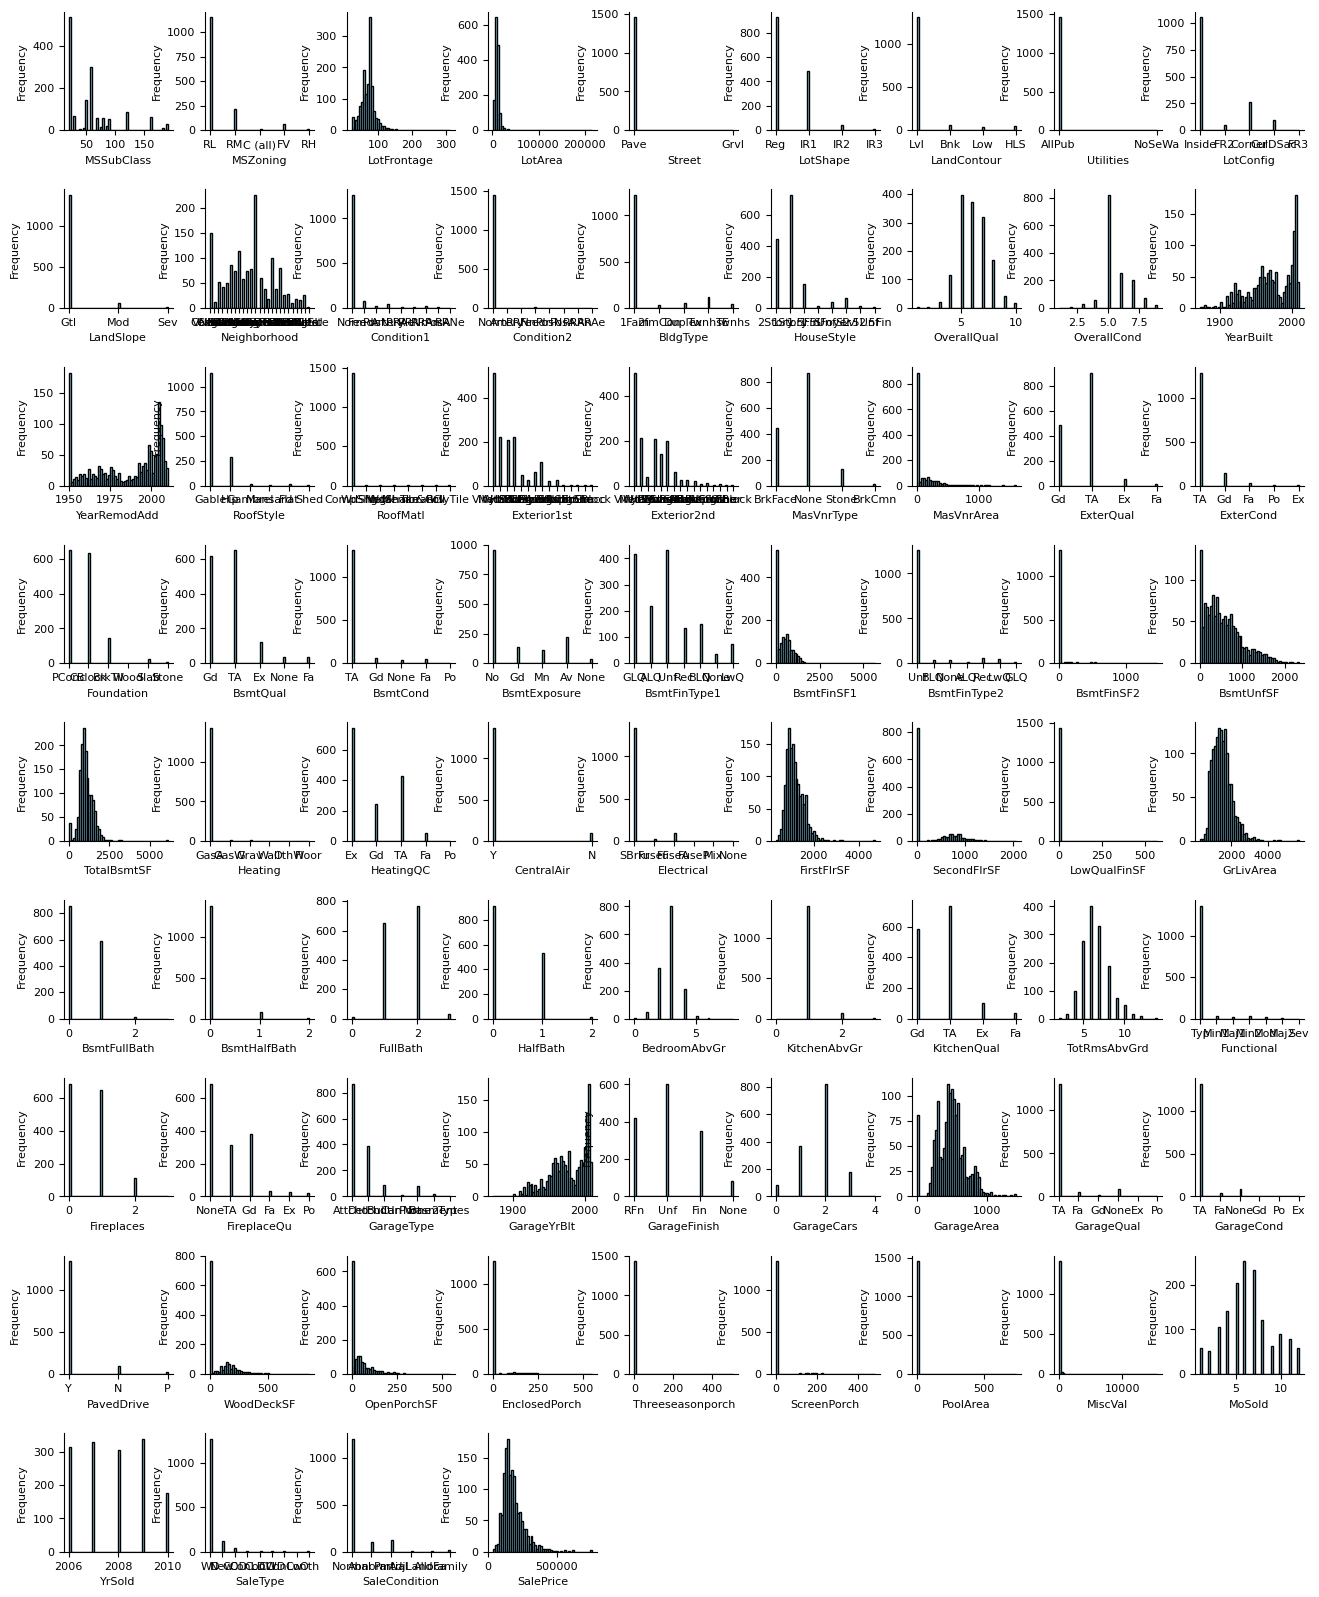

In [36]:
plot_histograms(df_train)

# Correlation among the variables

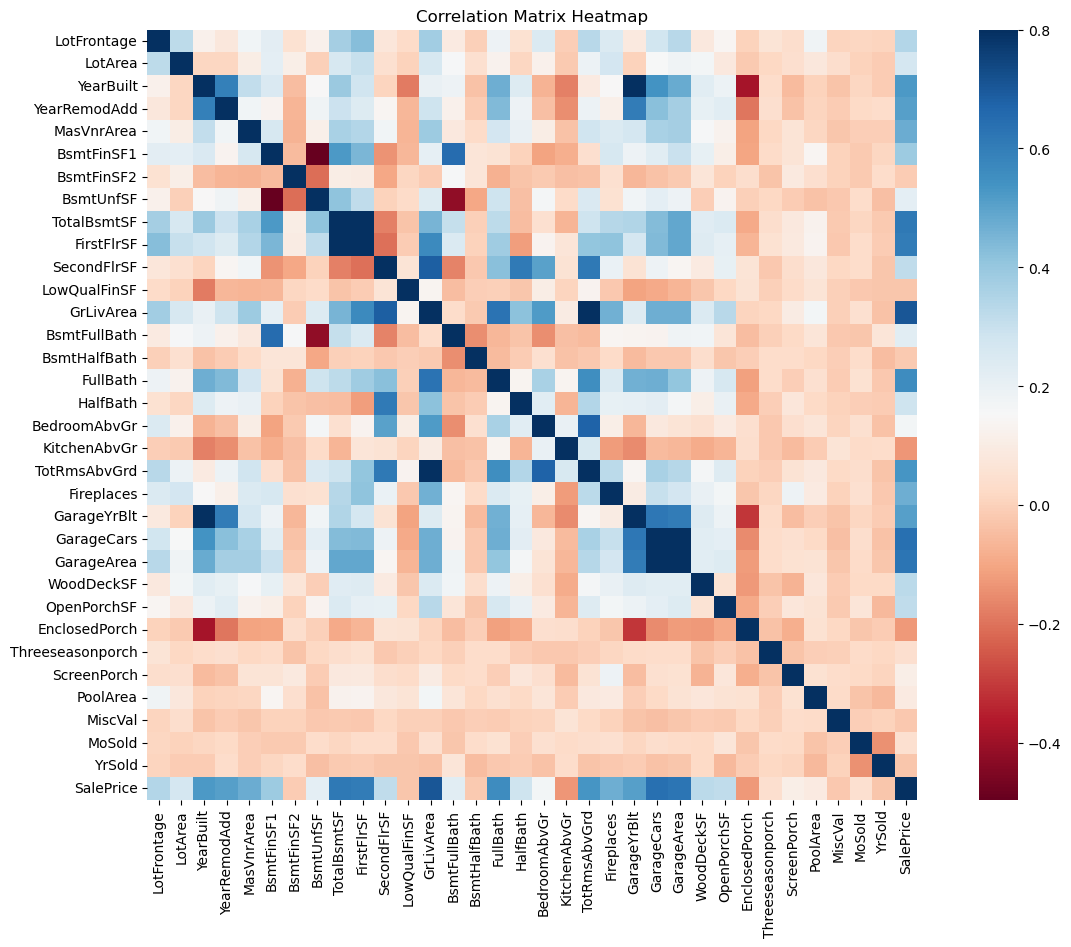

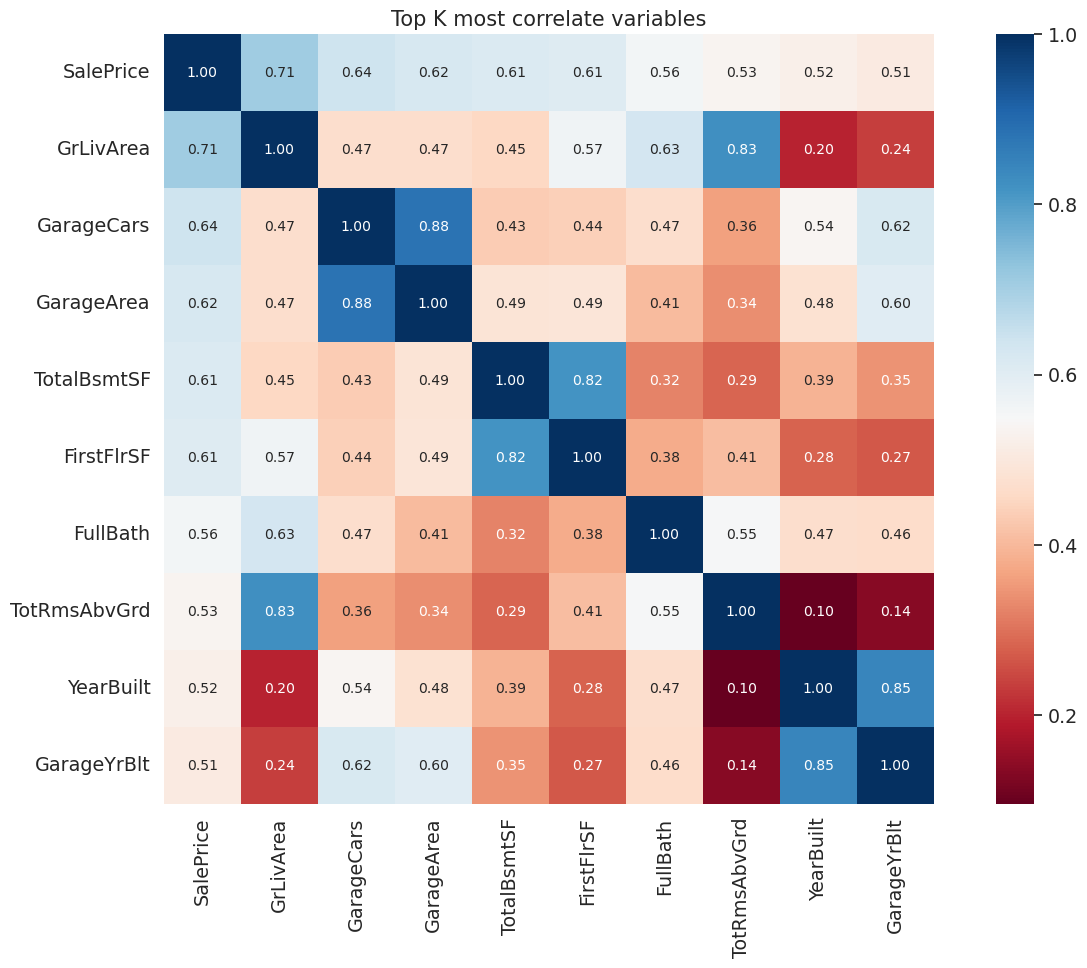

In [37]:
plot_heatmaps(df_train)

# Part 3: Predective analysis

In [76]:
#The two varibales contains the train & test splits of the datatset
#df_train, df_test